In [24]:
import pandas as pd
import nltk
from collections import Counter as counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import re
from sklearn.model_selection import train_test_split

In [11]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score

In [4]:
df_train = pd.read_csv('Train/Train.csv',nrows=10000)

In [6]:
df_train.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [101]:
# remove duplicate titles
df_train.drop_duplicates(subset=['Title'],inplace=True)

In [102]:
# tag count for each sentence
df_train['tag_count'] = df_train['Tags'].map(lambda x : len(x.split()))

In [103]:
### tag frequency 

In [21]:
count_vectorizer = CountVectorizer(tokenizer=lambda x : x.split())
tag_bow = count_vectorizer.fit_transform(df_train['Tags'])

In [25]:
# get all tokens
tags = count_vectorizer.get_feature_names()

# frequency of tokens
tag_frequency = tag_bow.sum(axis=0).getA1()

# create a dictionary of tags and their frequency in all questions
tag_freq_dict = dict(zip(tags,tag_frequency))

In [27]:
print(len(tag_freq_dict))

6124


In [52]:
print("Number of questions :", tag_bow.shape[0])
print("Number of unique tags :", tag_bow.shape[1])

Number of questions : 10000
Number of unique tags : 6124


In [29]:
# creating a dataframe from tag_freq_dict
tag_count_df = pd.DataFrame.from_dict(tag_freq_dict,orient='index').reset_index()
tag_count_df.rename(columns={'index':'tags',0:'counts'},inplace=True)
tag_count_df_sorted = tag_count_df.sort_values(['counts'],ascending=False)

tag_count_df_sorted.head()

,tags,counts
674,c#,778
2666,java,703
3937,php,701
2685,javascript,624
179,android,518


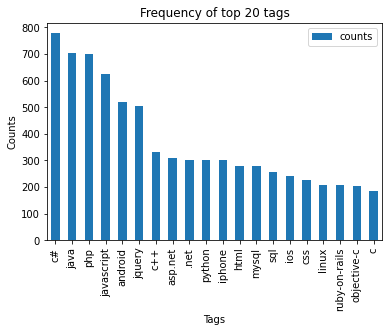

In [34]:
tag_count_df_sorted.head(20).plot(x = 'tags',kind='bar')
plt.title('Frequency of top 20 tags')
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

In [113]:
# Text preprocessing

In [36]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [37]:
qus_list=[]
qus_with_code = 0
len_before_preprocessing = 0 
len_after_preprocessing = 0 
for index,row in df_train.iterrows():
    title, body, tags = row["Title"], row["Body"], row["Tags"]
    if '<code>' in body:   
        qus_with_code+=1
    len_before_preprocessing+=len(title) + len(body)
    body=re.sub('<code>(.*?)</code>', '', body, flags=re.MULTILINE|re.DOTALL) # check and remove the code if the question body contains code in it.
    body = re.sub('<.*?>', ' ', str(body.encode('utf-8')))
    title=title.encode('utf-8')
    question=str(title)+" "+ body # combining title and body of the question
    # if the title of the question is to be given a high importance add the title multiple times to the body as shown below
    # question=str(title)+" "+str(title)+" "+ body 
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    qus_list.append(question)
    len_after_preprocessing += len(question)
df_train["question"] = qus_list
avg_len_before_preprocessing=(len_before_preprocessing*1.0)/df_train.shape[0]
avg_len_after_preprocessing=(len_after_preprocessing*1.0)/df_train.shape[0]

print( "Avg. length of questions(Title+Body) before preprocessing: ", avg_len_before_preprocessing)
print( "Avg. length of questions(Title+Body) after preprocessing: ", avg_len_after_preprocessing)
print ("% of questions containing code: ", (qus_with_code*100.0)/df_train.shape[0])

Avg. length of questions(Title+Body) before preprocessing:  1158.6922
Avg. length of questions(Title+Body) after preprocessing:  329.3853
% of questions containing code:  55.89


In [38]:
preprocessed_df = df_train[["question","Tags"]]

In [39]:
vectorizer = CountVectorizer(tokenizer = lambda x : x.split(),binary=True)
y_multilabel = vectorizer.fit_transform(preprocessed_df['Tags'])

In [45]:
# neglect tags of low frequency
def tags_to_consider(n):
    tag_i_sum = y_multilabel.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(tag_i_sum)), key=lambda i: tag_i_sum[i], reverse=True) # sorting indices opf tags based on the frequecny
    yn_multilabel=y_multilabel[:,sorted_tags_i[:n]] 
    return yn_multilabel

In [46]:
def questions_covered_fn(numb):
    yn_multilabel = tags_to_consider(numb)
    x= yn_multilabel.sum(axis=1)
    return (np.count_nonzero(x==0))

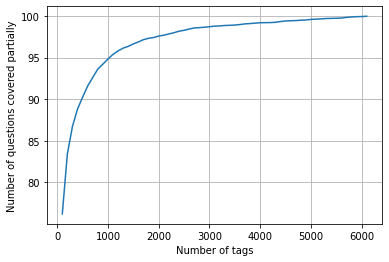

94.83 % of questions covered by 1000 tags


In [56]:
# eda to select the number of tags to consider
questions_covered = []
total_tags=y_multilabel.shape[1]
total_qus=preprocessed_df.shape[0]
for i in range(100, total_tags, 100):
    questions_covered.append(np.round(((total_qus-questions_covered_fn(i))/total_qus)*100,3))
    
plt.plot(np.arange(100,total_tags, 100),questions_covered)
plt.xlabel("Number of tags")
plt.ylabel("Number of questions covered partially")
plt.grid()
plt.show()
print(questions_covered[9],"% of questions covered by 1000 tags")

In [47]:
yx_multilabel = tags_to_consider(1000)

In [49]:
# splitting the data into train and test 
X_train, X_test, y_train, y_test = train_test_split(preprocessed_df, yx_multilabel, test_size = 0.2,random_state = 42)

In [50]:
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, tokenizer = lambda x: x.split(), ngram_range=(1,3))
X_train_multilabel = vectorizer.fit_transform(X_train['question'])
X_test_multilabel = vectorizer.transform(X_test['question'])

In [57]:
clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l2'))
clf.fit(X_train_multilabel, y_train)
y_pred = clf.predict(X_test_multilabel)

<2000x1000 sparse matrix of type '<class 'numpy.intc'>'
	with 948 stored elements in Compressed Sparse Row format>

In [60]:
# model evaluation

In [64]:
# since there is a huge imbalance in tags frequency ' Micro-averaged metrics' are appropriate for this case
precision = precision_score(y_test,y_pred,average='micro')
recall    = recall_score(y_test,y_pred,average='micro')
f1_score  = f1_score(y_test,y_pred,average='micro')

print("precision, recall, f1_score : ",(precision,recall,f1_score))

precision, recall, f1_score :  (0.7267932489451476, 0.15644868301544052, 0.25747384155455905)


In [ ]:
            # TODO # 
# Try with other linear models 
# Try with deep learning techniques